In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick 
import pandas_datareader.data as web
from datetime import date

In [3]:
report_start = date.fromisoformat('2008-10-01')
report_end = date.today()


In [4]:
nom_2_real_conv_factors = web.get_data_fred('CPIAUCSL', start=report_start, end=report_end)
nom_2_real_conv_factors['conv_factor'] = nom_2_real_conv_factors.CPIAUCSL.iloc[-1] / nom_2_real_conv_factors.CPIAUCSL

# Convert into pandas.Series
nom_2_real_conv_factors = nom_2_real_conv_factors.conv_factor

In [5]:
report_start = date(2020, month=5, day=1)

In [6]:
m2_components = web.get_data_fred(['MBCURRCIR', 'M1NS', 'M2NS'], start=report_start, end=report_end)

m2_total = m2_components.M2NS.copy()
m2_total.rename('M2 Total', inplace=True)

# Converting into billions of USD
m2_components.MBCURRCIR /= 1000.

# Subtracting smaller money aggregates from larger ones so that we have only additional parts contributed
# by each of the larger aggregates left
m2_components.M2NS -= m2_components.M1NS
m2_components.M1NS -= m2_components.MBCURRCIR

In [7]:
M2_COMPOSITION_TITLE = 'Composition of US M2 Money Supply'
REALM2_COMPOSITION_TITLE = 'Composition of US Real M2 Money Supply'
IN_USD_FORMATER = ' in {:%Y-%m} USD'
LEFT_Y_AXIS_LABEL = ' Billions of USD'
m2_components.rename(
    columns={'MBCRRCIR': 'MB Currency in Circulation', 'M1NS': 'M1 Add-ons', 'M2NS':'M2 Add-ons'},
    inplace=True
)
pd.options.display.float_format = None
pd.concat([m2_total, m2_components], axis=1).tail(12)

,M2 Total,MBCURRCIR,M1 Add-ons,M2 Add-ons
DATE,,,,
2023-03-01,21027.1,2313.1,16763.8,1950.2
2023-04-01,20842.9,2323.7,16419.9,2099.3
2023-05-01,20711.2,2334.0,16157.8,2219.4
2023-06-01,20749.0,2342.9,16089.9,2316.2
2023-07-01,20724.0,2339.1,15995.3,2389.6
2023-08-01,20695.2,2331.1,15895.6,2468.5
2023-09-01,20668.9,2327.7,15805.3,2535.9
2023-10-01,20636.2,2324.9,15697.4,2613.9
2023-11-01,20722.8,2328.0,15694.6,2700.2


In [8]:
# Convert from nominal into real money suppy
m2real_total = (m2_total * nom_2_real_conv_factors).dropna()
m2real_components = m2_components.copy()
m2real_components = m2real_components.multiply(nom_2_real_conv_factors, axis=0).dropna()

m2real_total.rename('Real M2 Total', inplace=True)
m2real_components.rename(
    columns={'MB Currency in Circulation':'Real MB Currency in Circulation',
             'M1 Add-ons': 'Real M1 Add-ons', 'M2 Add-ons':'Real M2 Add-ons'},
    inplace=True
)

In [9]:
pd.concat([m2real_total, m2real_components], axis=1).tail(18)

,Real M2 Total,MBCURRCIR,Real M1 Add-ons,Real M2 Add-ons
DATE,,,,
2022-09-01,22616.948650,2401.931326,18931.922194,1283.095130
2022-10-01,22409.766497,2394.794446,18632.247130,1382.724921
2022-11-01,22362.780598,2397.386264,18476.319607,1489.074727
2022-12-01,22383.003537,2401.921948,18370.465811,1610.615778
2023-01-01,22118.145501,2389.990521,17969.576855,1758.578124
2023-02-01,21873.259193,2381.575853,17621.673045,1870.010295
2023-03-01,21757.819320,2393.483261,17346.364050,2017.972009
2023-04-01,21475.549338,2394.231801,16918.297002,2163.020536
2023-05-01,21316.427327,2402.204671,16629.966852,2284.255804


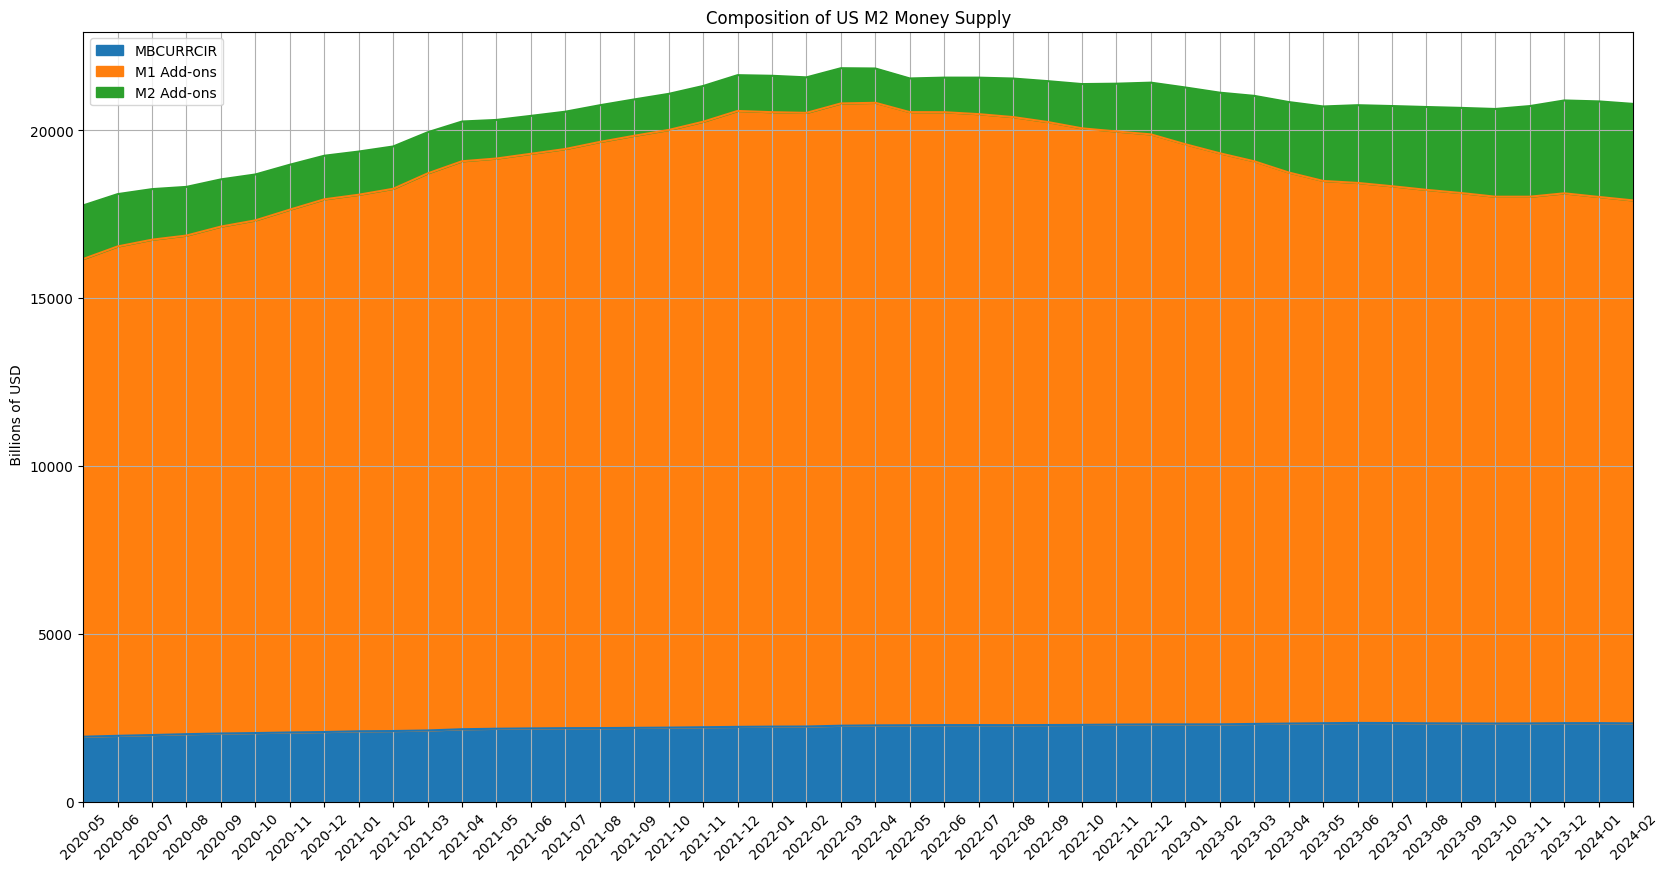

In [10]:
ax = m2_components.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                             xticks=m2_components.index, xlabel='', rot=45,
                             ylabel=LEFT_Y_AXIS_LABEL)

_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components.index)))

In [11]:
idxmax = m2_total.idxmax()

print('Nominal M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2_total.loc[idxmax], idxmax))

print('Nominal M2 money supply shrank by {:>8.2f}bn since (as of month {:%Y-%m})'
      .format(m2_total.iloc[-1]-m2_total.loc[idxmax], m2_total.index[-1]))

print('Nominal M2 money supply changed by {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2_total.iloc[-1]-m2_total.iloc[-2], m2_total.index[-2], m2_total.iloc[-1]))

Nominal M2 money supply maximum of 21851.30bn reached in month 2022-03
Nominal M2 money supply shrank by -1063.70bn since (as of month 2024-02)
Nominal M2 money supply changed by   -74.90bn since 2024-01 to 20787.60bn


In [12]:
m2_components.iloc[-1, :] - m2_components.iloc[-2,:]

MBCURRCIR     -7.5
M1 Add-ons   -96.2
M2 Add-ons    28.8
dtype: float64

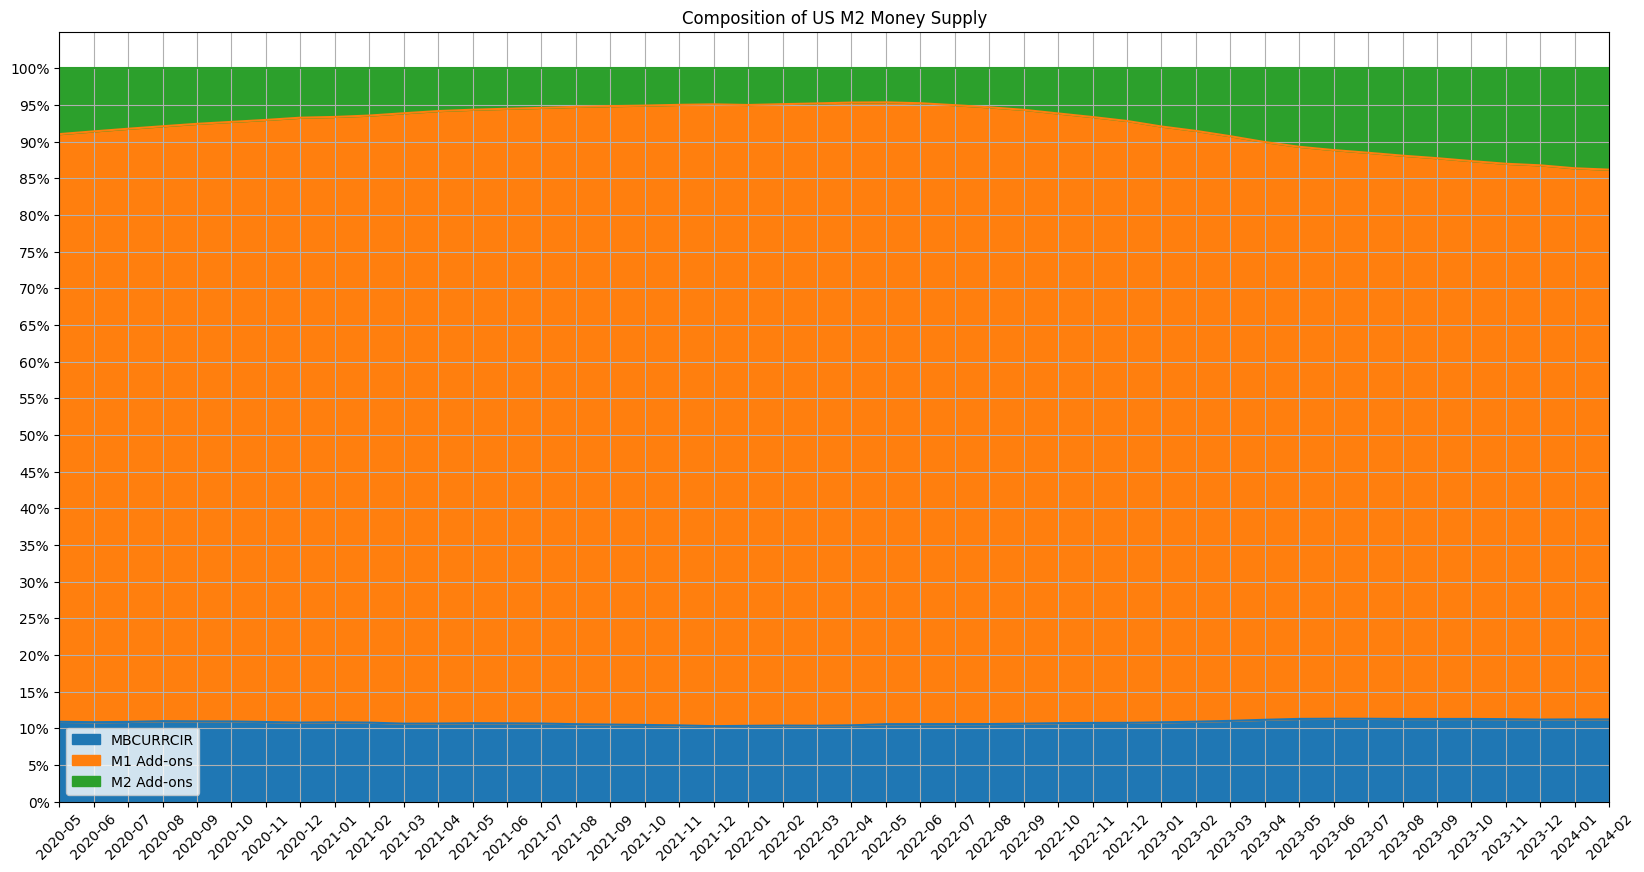

In [13]:
# Converting to percentages by dividing by total M2 Money Supply
# Dividing by the total M2 Money Supply
m2_components_pct = m2_components.divide(m2_total, axis=0)
m2_components_pct *= 100

ax = m2_components_pct.plot.area(figsize=(20,10), grid=True, title=M2_COMPOSITION_TITLE,
                              xticks=m2_components_pct.index, xlabel='', rot=45,
                              yticks=np.arange(0, 101, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_pct.index)))

In [14]:
m2_components_pct.iloc[-1,:] - m2_components_pct.iloc[-2,:]

MBCURRCIR     0.004277
M1 Add-ons   -0.191991
M2 Add-ons    0.187714
dtype: float64

In [15]:
m2_components_pct.iloc[-1,:]

MBCURRCIR     11.204757
M1 Add-ons    74.961034
M2 Add-ons    13.834209
Name: 2024-02-01 00:00:00, dtype: float64

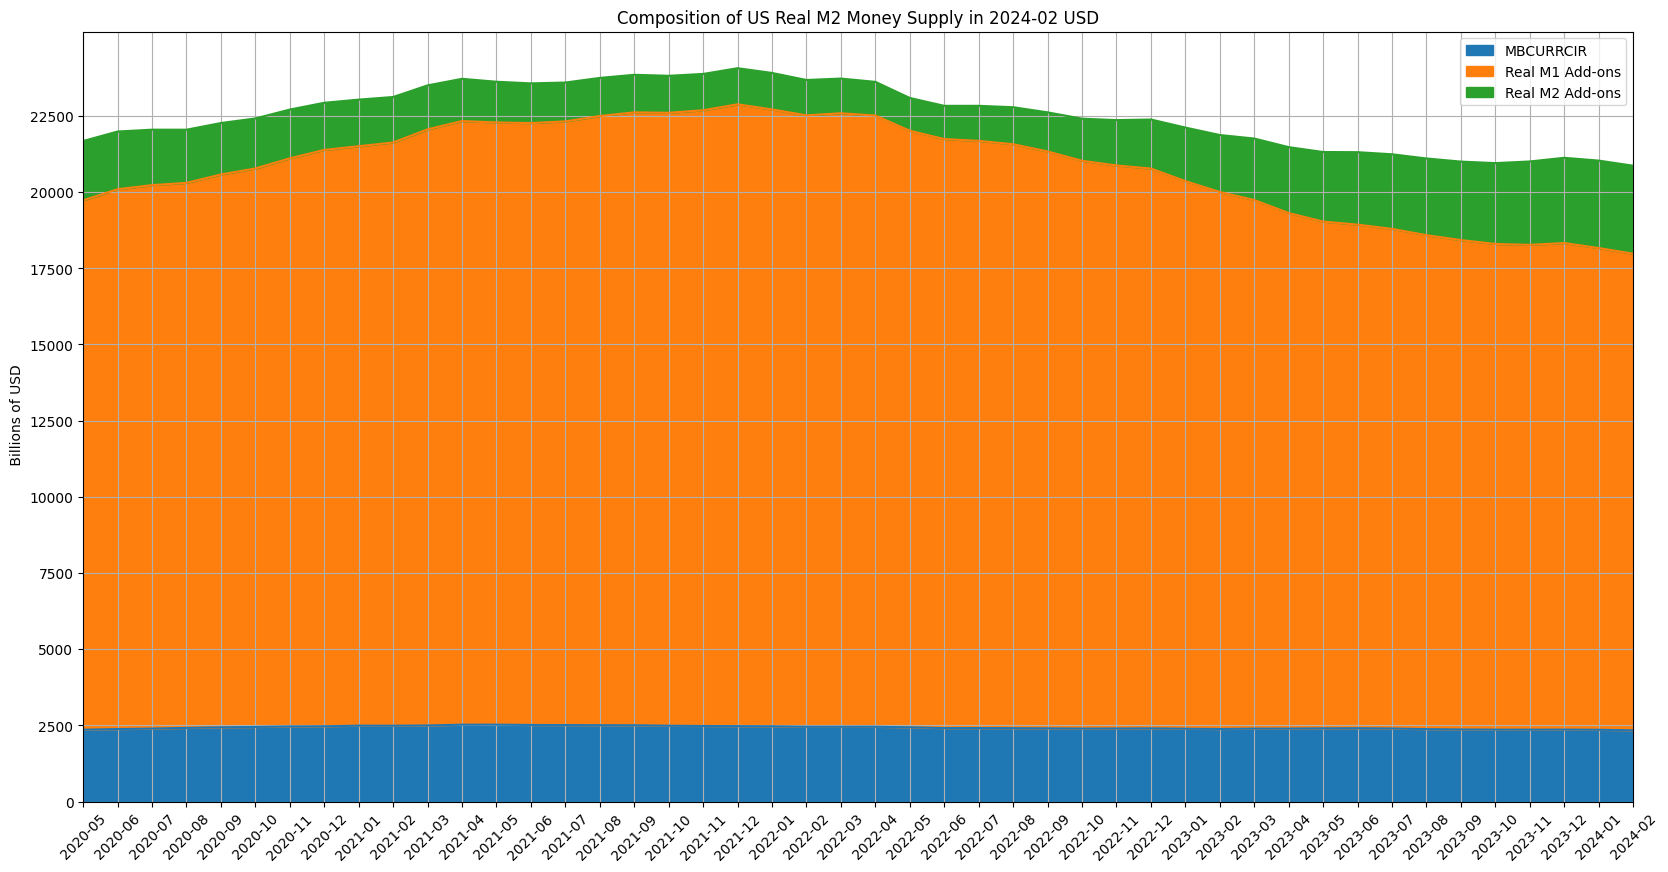

In [16]:
ax = m2real_components.plot.area(
    figsize=(20,10), grid=True,
    title=REALM2_COMPOSITION_TITLE + IN_USD_FORMATER.format(m2real_components.index[-1].date()),
    xticks=m2_components.index, xlabel='', rot=45,
    ylabel=LEFT_Y_AXIS_LABEL, yticks=np.arange(0, 25e3, 2.5e3)
)
_=ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2real_components.index)))

In [17]:
idxmax = m2real_total.idxmax()
print('Real M2 money supply maximum of {:>8.2f}bn reached in month {:%Y-%m}'
      .format(m2real_total.loc[idxmax], idxmax))

print('Real M2 money supply shrank by {:>8.2f}bn since (as of month) {:%Y-%m})'
      .format(m2real_total.iloc[-1]-m2real_total.loc[idxmax], m2real_total.index[-1]))\

print('Real M2 money supply shrank by {:>8.2f}bn since {:%Y-%m} to {:.2f}bn'
      .format(m2real_total.iloc[-1]-m2real_total.iloc[-2], m2real_total.index[-2], m2real_total.iloc[-1]))

Real M2 money supply maximum of 24065.93bn reached in month 2021-12
Real M2 money supply shrank by -3199.74bn since (as of month) 2024-02)
Real M2 money supply shrank by  -167.76bn since 2024-01 to 20866.19bn


In [18]:
m2real_components.iloc[-1,:] - m2real_components.iloc[-2,:]

MBCURRCIR          -17.897073
Real M1 Add-ons   -166.135775
Real M2 Add-ons     16.275794
dtype: float64

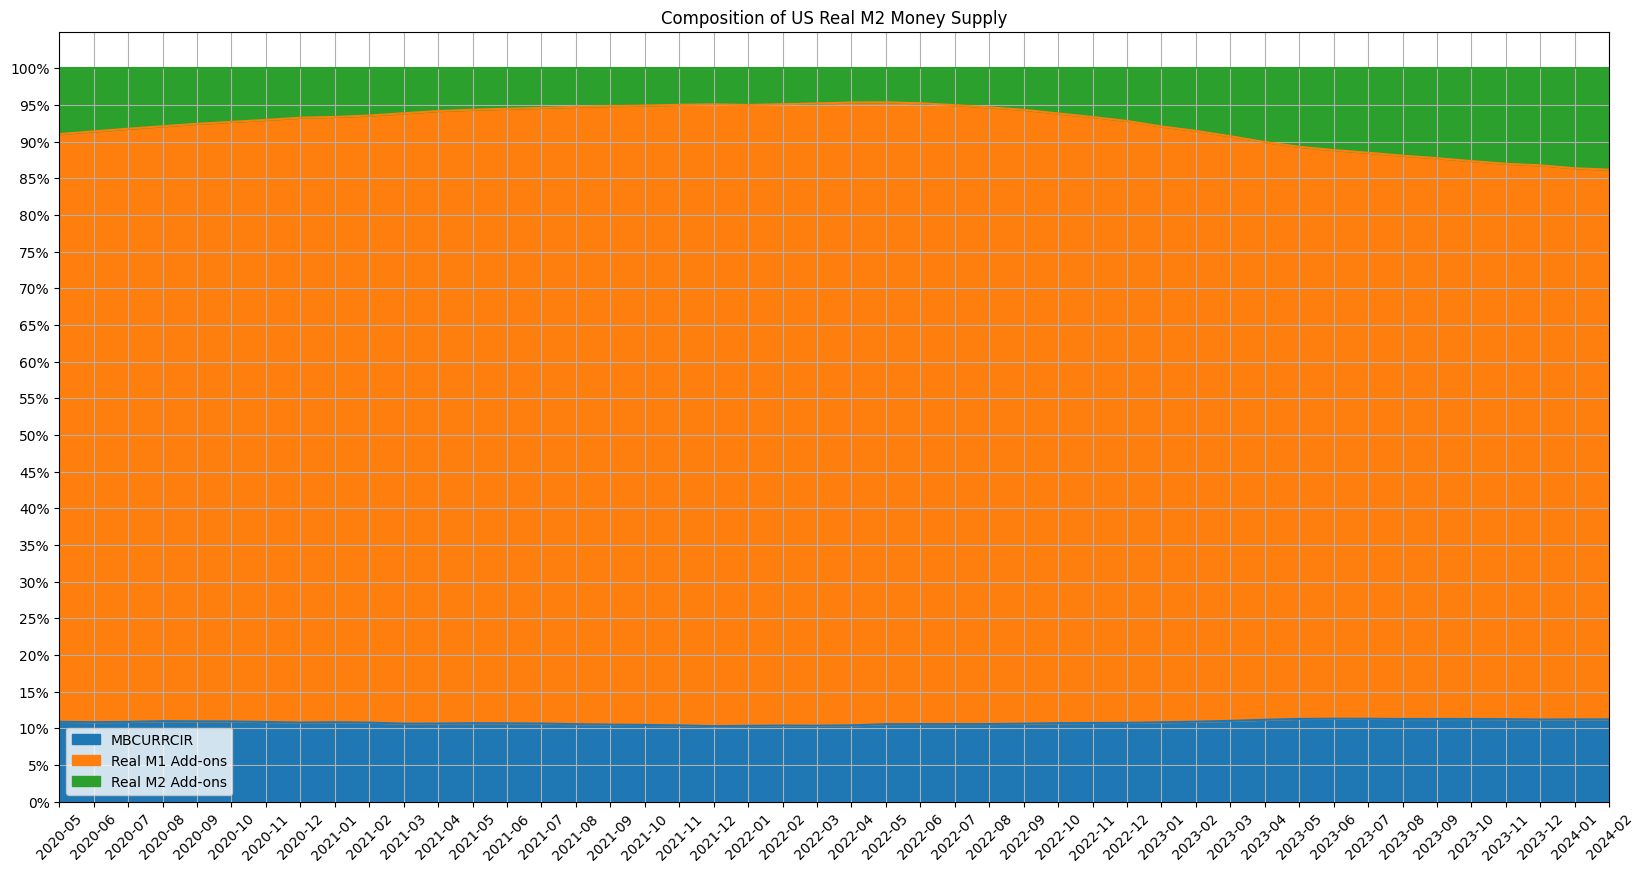

In [20]:
# Converting to percentages by dividing by total M2 Money Supply.
# Dividing by the total M2 Money Supply
m2real_components_pct = m2real_components.divide(m2real_total, axis=0)
m2real_components_pct *= 100

ax = m2real_components_pct.plot.area(figsize=(20,10), grid=True, title=REALM2_COMPOSITION_TITLE,
                                     xticks=m2real_components_pct.index, xlabel='', rot=45,
                                     yticks=np.arange(0, 101, 5))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_pct.index)))


In [21]:
m2_components_speed = (m2_components - m2_components.shift(1)).dropna()

In [22]:
m2_annual_rate = pd.concat([m2_total, m2_components], axis=1).pct_change(12)
m2_annual_rate = m2_annual_rate.loc['2021-05':]

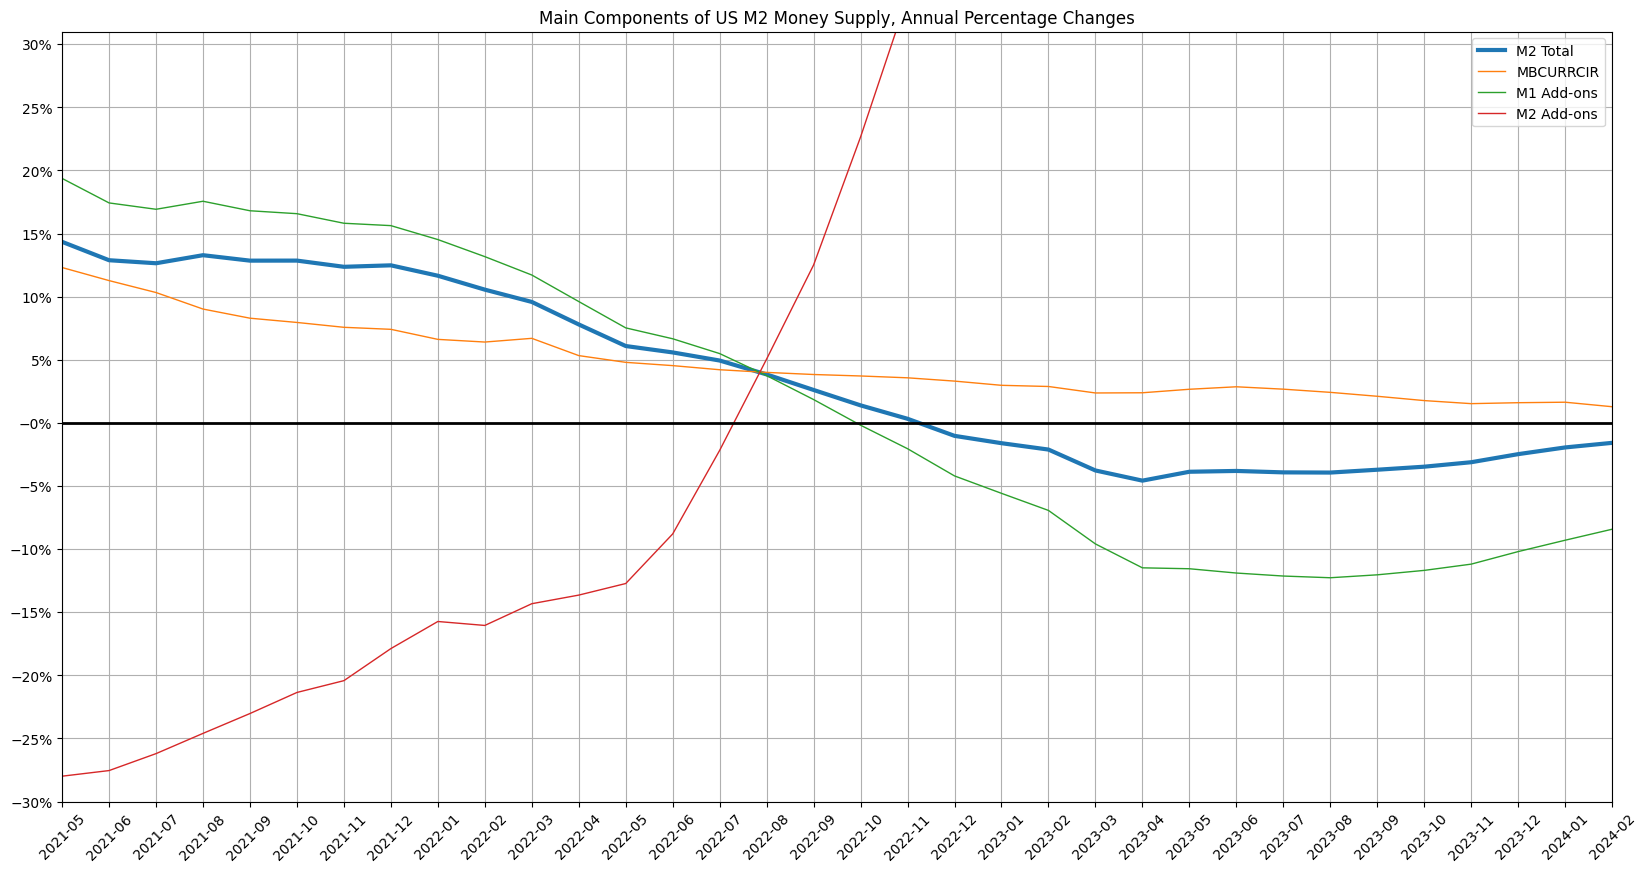

In [23]:
ax = m2_annual_rate.iloc[:,:1].plot(figsize=(20,10), grid=True,
                                    title='Main Components of US M2 Money Supply, Annual Percentage Changes',
                                    xticks=m2_annual_rate.index, xlabel='', rot=45, ylim=(-.3,.31), yticks=np.arange(-.30, 0.31,.05),
                                    linewidth=3)

m2_annual_rate.iloc[:,1:].plot(ax=ax, grid=True, xticks=m2_annual_rate.index, xlabel='', rot=45, linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_annual_rate.index)))

In [24]:
pd.options.display.float_format = (lambda x: '{:.3%}'.format(x) if x < 100 else '{:,.0f}bn'.format(x))
m2_annual_rate.tail(12)

,M2 Total,MBCURRCIR,M1 Add-ons,M2 Add-ons
DATE,,,,
2023-03-01,-3.772%,2.368%,-9.592%,85.840%
2023-04-01,-4.577%,2.384%,-11.485%,105.270%
2023-05-01,-3.874%,2.661%,-11.558%,121.254%
2023-06-01,-3.810%,2.858%,-11.897%,124.808%
2023-07-01,-3.923%,2.669%,-12.135%,119.754%
2023-08-01,-3.938%,2.416%,-12.271%,114.914%
2023-09-01,-3.713%,2.106%,-12.039%,108.236%
2023-10-01,-3.473%,1.764%,-11.688%,98.158%
2023-11-01,-3.119%,1.522%,-11.192%,89.581%


In [25]:
M2_COMPOSITION_SPEED = 'Speed of changes in US M2 Money Supply in Billions of USD per month'
M2_COMPOSITION_CHANGES = 'Changes in Components of US M2 Money Supply in Billions of USD'
M2REAL_COMPONENTS_SPEED = 'Speed of changes in US Real M2 Money Supply in Billion of USD per month'
M2REAL_COMPONENTS_CHANGES = 'Changes in Components of US Real M2 Money Supply in Billion of USD'
LEFT_Y_AXIS_LABEL = 'Billions of USD'


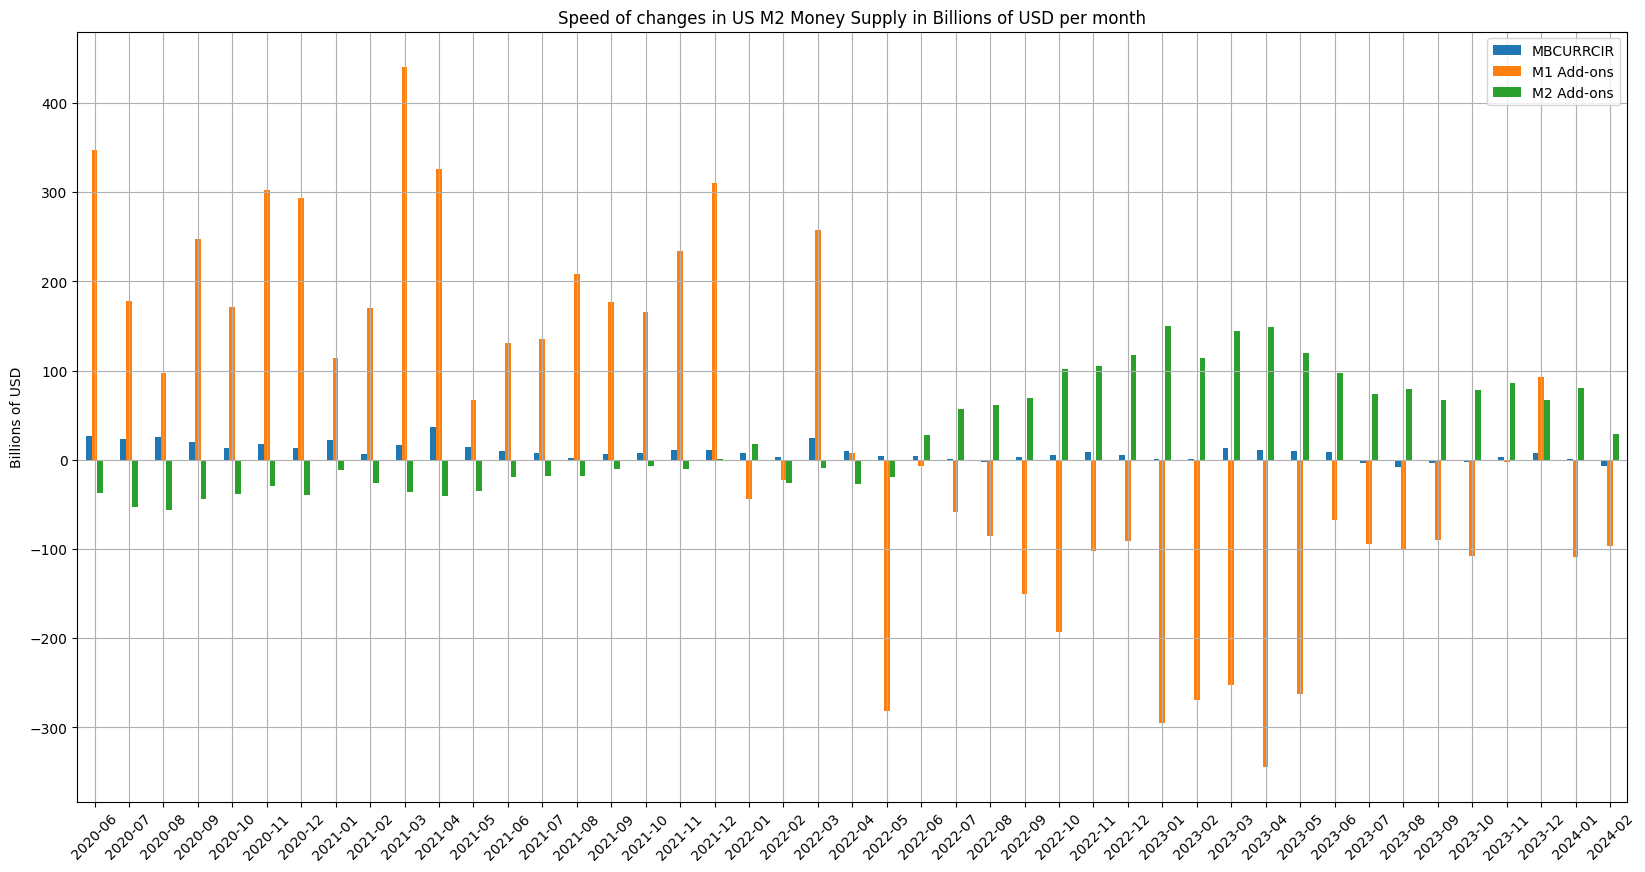

In [26]:
ax = m2_components_speed.iloc[:,:].plot.bar(figsize=(20,10), grid=True,
                                            title=M2_COMPOSITION_SPEED,
                                            xlabel='', rot=45,
                                            ylabel=LEFT_Y_AXIS_LABEL)

_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_components_speed.index)))

In [27]:
periods = [12, 18]

In [28]:
# If you want to include currency in circulation, use iloc[-1] in the expression below
m2_df_comp_changes = pd.DataFrame([(m2_components - m2_components.shift(period)).iloc[-1, 1:] for period in periods],
                                  index=['Over past {:d} month'.format(period) for period in periods])

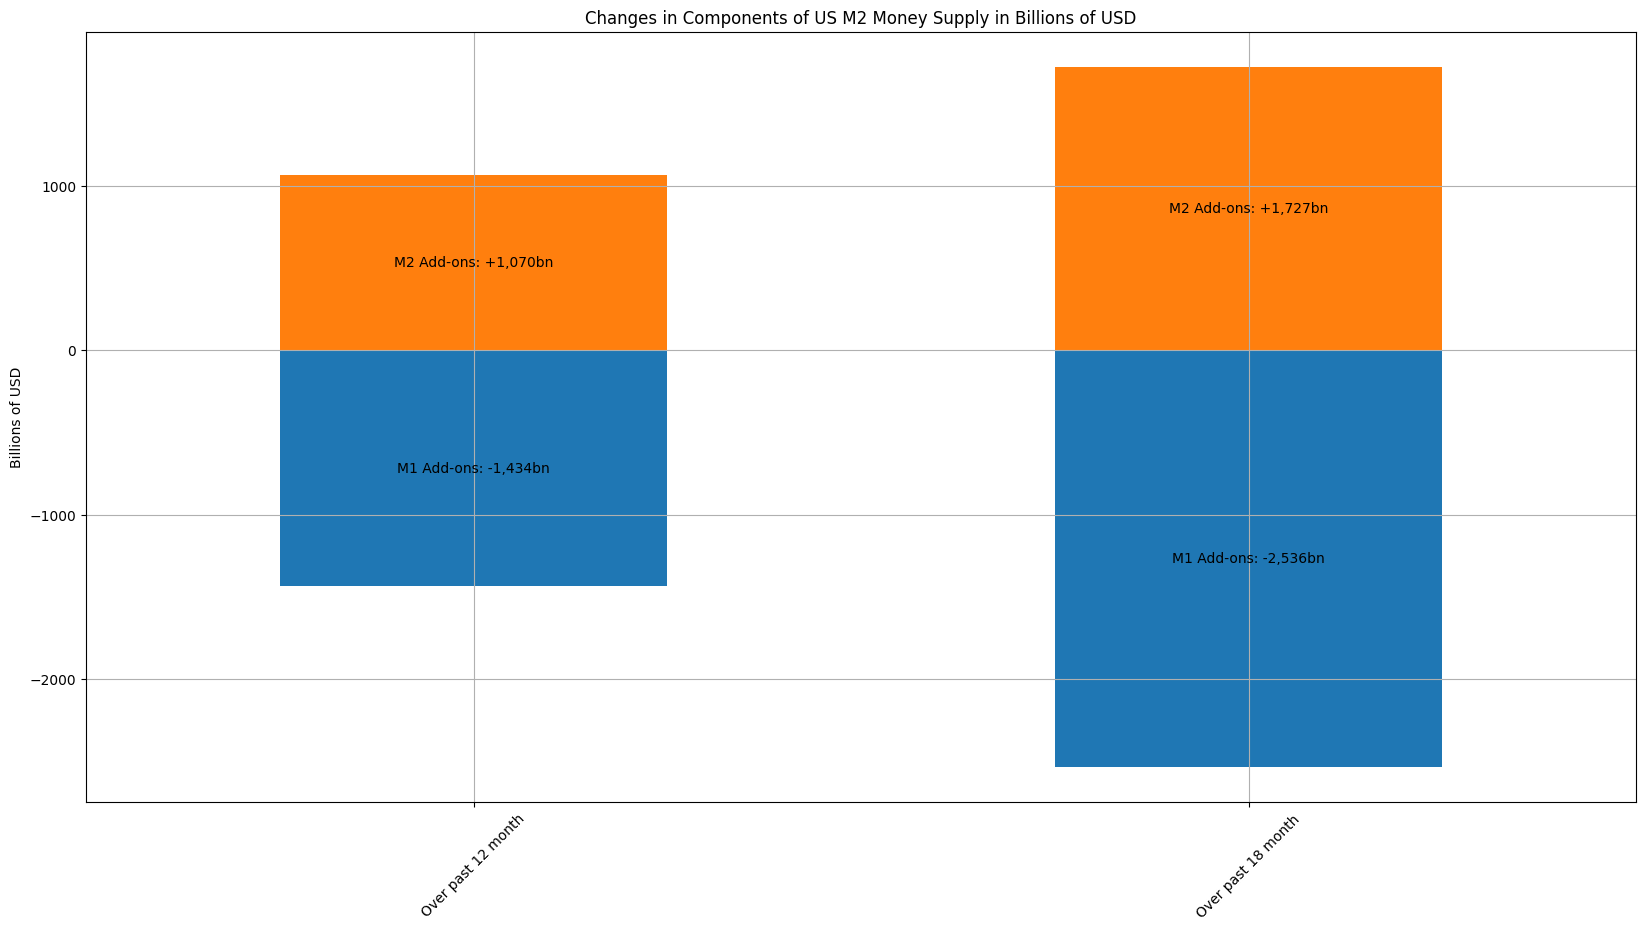

In [29]:
ax = m2_df_comp_changes.plot.bar(figsize=(20,10), grid=True, title=M2_COMPOSITION_CHANGES,
                                 stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)

ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:+,.0f}bn', label_type='center')

In [30]:
report_start = date(2008, month=10,day=1)
mbase_reserves = web.get_data_fred(['BOGMBBM','GS1M'], start=report_start, end=report_end)

# Converting reserve balances into billions of USD
mbase_reserves.BOGMBBM /= 1000

# Converting 1-month treasury yields into percentage points
mbase_reserves.GS1M /= 100.

iorr = web.get_data_fred('IORR', start=report_start, end=report_end).resample('MS').mean() / 100.
iorb = web.get_data_fred('IORB', start=report_start, end=report_end).resample('MS').mean() / 100.
iorb = pd.concat([iorr.IORR, iorb.IORB])

In [31]:
#Approximate the latest value of Reserve Balances
reserve_balances = web.get_data_fred(['TERMT', 'WLODLL'], start=report_start, end=report_end).asfreq('W-Wed')
reserve_balances = reserve_balances.sum(axis=1).resample('MS').mean() / 1000
reserve_balances.rename('BOGMBBM', inplace=True)
idx = reserve_balances.index.difference(mbase_reserves.BOGMBBM.dropna().index)

# Approximate the latest value of 1-month treasury securities
latest_1m_tr_yield = web.get_data_fred('DGS1MO', start=report_start, end=report_end).DGS1MO / 100.
latest_1m_tr_yield = latest_1m_tr_yield.resample('MS').mean()
latest_1m_tr_yield.rename('GS1M', inplace=True)

# First update the missing values in mbase_reserve dataframe
mbase_reserves.update(pd.concat([reserve_balances[idx], latest_1m_tr_yield[idx]], axis=1))

# Now append the missing rows if any
idx = reserve_balances.index.difference(mbase_reserves.index)
mbase_reserves = pd.concat([mbase_reserves, pd.concat([reserve_balances[idx], latest_1m_tr_yield[idx]], axis=1)])

In [32]:
irt_reserves = pd.concat([mbase_reserves.iloc[:, 0:], mbase_reserves.BOGMBBM * nom_2_real_conv_factors,
                         iorb, iorb-mbase_reserves.iloc[:,1]], axis=1)

irt_reserves.rename(
    columns={'BOGMBBM': 'MB Reserve Balance', 0:'MB Real Reserve Balances',
             1: 'Interest Rate on Reserve Balances',
             2: 'Interest on Reserve Balance-1m Treasury yield',},
    inplace=True
)

In [33]:
irt_reserves

,MB Reserve Balance,GS1M,MB Real Reserve Balances,Interest Rate on Reserve Balances,Interest on Reserve Balance-1m Treasury yield
DATE,,,,,
2008-10-01,285bn,0.290%,410bn,1.335%,1.045%
2008-11-01,577bn,0.090%,845bn,0.983%,0.893%
2008-12-01,788bn,0.030%,"1,164bn",0.613%,0.583%
2009-01-01,825bn,0.050%,"1,216bn",0.250%,0.200%
2009-02-01,667bn,0.220%,979bn,0.250%,0.030%
...,...,...,...,...,...
2023-12-01,"3,492bn",5.540%,"3,531bn",5.400%,-0.140%
2024-01-01,"3,507bn",5.540%,"3,536bn",5.400%,-0.140%
2024-02-01,"3,568bn",5.490%,"3,581bn",5.400%,-0.090%


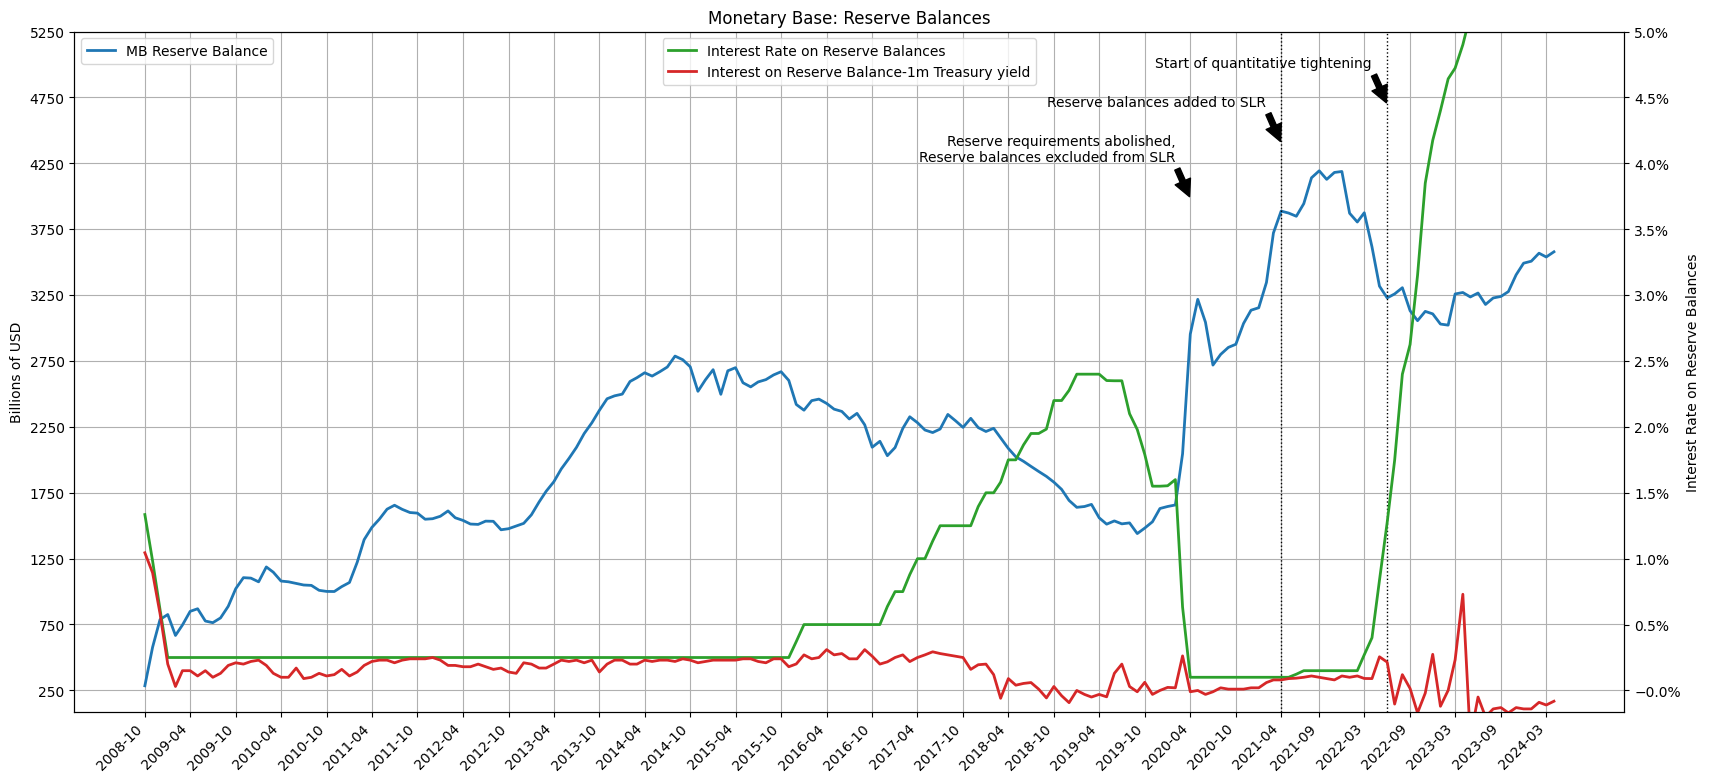

In [34]:
LEFT_Y_AXIS_LABEL = 'Billions of USD'
RIGHT_Y_AXIS_LABEL = 'Interest Rate on Reserve Balances'
RESERVE_REQ_ABOLISH_DATE = '2020-04-01'
SLR_REINTRODUCTION_DATE = '2021-04-01'
QUANTITATIVE_TIGHTENING_DATE = '2022-06-01'

ax = irt_reserves.iloc[:,:1].plot(figsize=(20,10), grid=True,
                                 title='Monetary Base: Reserve Balances', ylabel=LEFT_Y_AXIS_LABEL,
                                 xticks=irt_reserves.index[::6], xlabel='', rot=45, linewidth=2,
                                 yticks=np.arange(250, 5251, 500))
ax.axvline(irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE)], color='k',
           linestyle=':', linewidth=1)
ax.axvline(irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE)], color='k',
           linestyle=':', linewidth=1)
x1 = irt_reserves.index[irt_reserves.index.get_loc(RESERVE_REQ_ABOLISH_DATE)]
y1 = irt_reserves.iloc[:,0].max() * .95
x2 = irt_reserves.index[irt_reserves.index.get_loc(RESERVE_REQ_ABOLISH_DATE) - 2]
y2 = y1 + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Reserve requirements abolished,\nReserve balances excluded from SLR',
            xy=(x1, y1), xytext=(x2, y2), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1_ = irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE)]
y1_ = irt_reserves.iloc[:,0].max() * 1.05
x2_ = irt_reserves.index[irt_reserves.index.get_loc(SLR_REINTRODUCTION_DATE) - 2]
y2_ = y1_ + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Reserve balances added to SLR',
            xy=(x1_, y1_), xytext=(x2_, y2_), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

x1__ = irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE)]
y1__ = irt_reserves.iloc[:,0].max() * 1.12
x2__ = irt_reserves.index[irt_reserves.index.get_loc(QUANTITATIVE_TIGHTENING_DATE) - 2]
y2__ = y1__ + irt_reserves.iloc[:,0].max() / 15
ax.annotate('Start of quantitative tightening',
            xy=(x1__, y1__), xytext=(x2__, y2__), horizontalalignment='right',
            arrowprops=dict(facecolor='black', shrink=0.05))

_ = ax.legend(loc='upper left')
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2 = irt_reserves.iloc[:,3:].plot(ax=ax2, linewidth=2, linestyle='-', ylabel=RIGHT_Y_AXIS_LABEL,
     xticks=irt_reserves.index[::6], color=['#2ca02c','#d62728'], ylim=(-.0016, .05), yticks=np.arange(-.0, .051, .005))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.set_xticklabels(list(map('{:%Y-%m}'.format, irt_reserves.index[::6])))
_ = ax2.legend(loc='upper center')

In [35]:
m2_total = web.get_data_fred('M2NS', start=irt_reserves.index[0]).M2NS

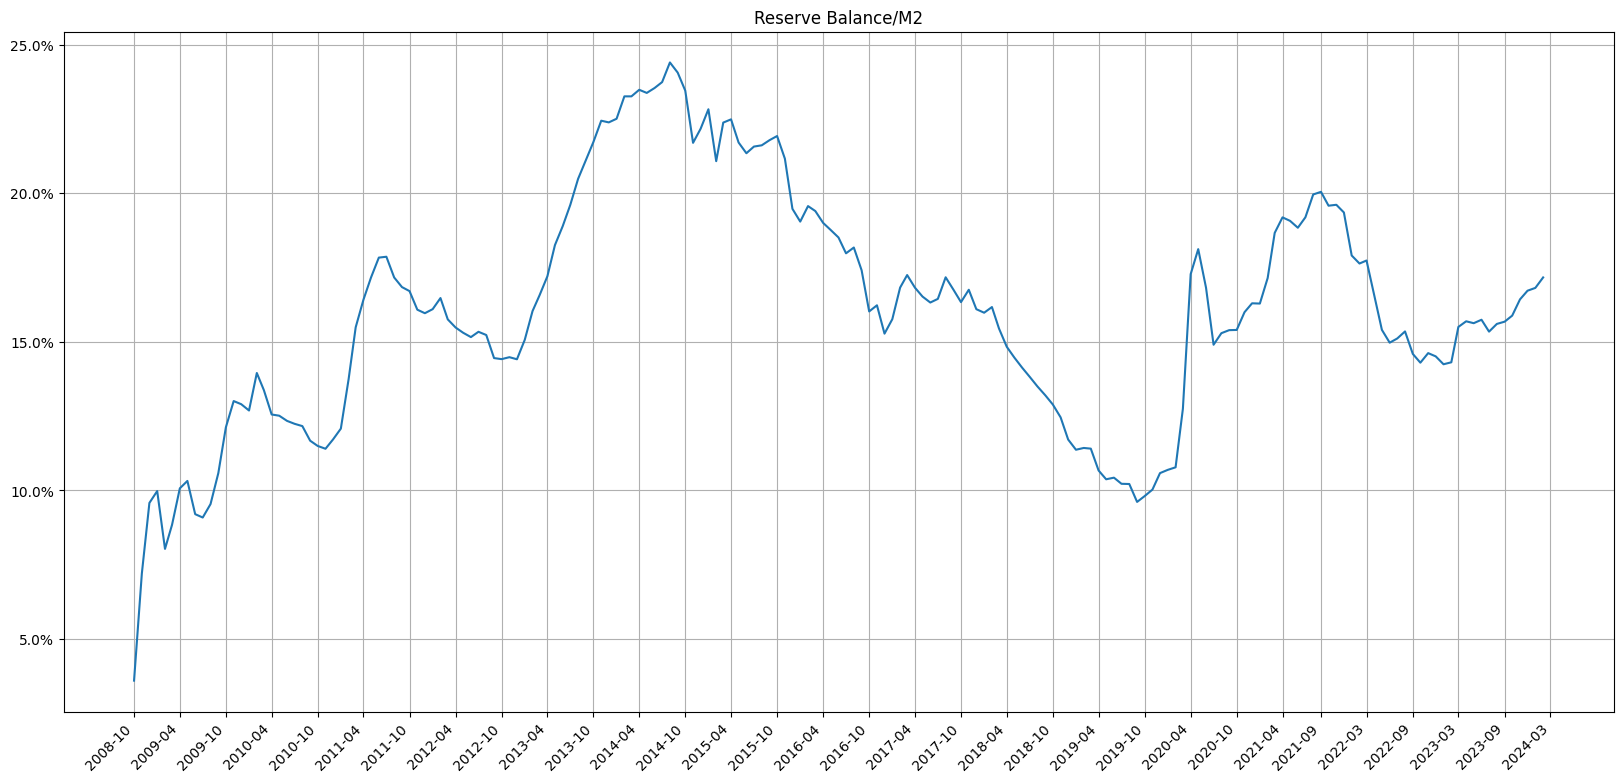

In [36]:
ax = (irt_reserves.iloc[:, 0] / m2_total).plot(figsize=(20,10), grid=True,
                                               title='Reserve Balance/M2',
                                               xticks=irt_reserves.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, irt_reserves.index[::6])))